In [21]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 

In [20]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)
def remove_noise(binary_image):
    ret_val = erode(dilate(binary_image))
    ret_val = invert(ret_val)
    return ret_val

In [3]:
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)

In [4]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    remove_conts = []
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for i,con1 in enumerate(contours):
        a,b,c,d = cv2.boundingRect(con1)
        for j,con2 in enumerate(contours):
            if i != j:
                x,y,w,h = cv2.boundingRect(con2)
                if a <= x and a >= x+w:
                    remove_conts.append(i)
    if flag_video:
        for i,c in  enumerate(contours):
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box) 
            if box[0:0]-box[2:0] < 10:
                lx = [box[0:0],box[2:0]]
                ly = [box[0:1],box[1:1]]
                m = (ly[2]-ly[1])/(lx[2]-lx[1])
                q = ly[2]-m*lx[2]
                for cont in contours:
                    x,y,w,h = cv2.boundingRect(contour)
                    if y != x*m+q:
                        remove_conts.append(i)
    remove_conts = list(set(remove_conts))
    remove_conts.sort()
    for c in reversed(remove_conts):
        del contours[c]
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 50 and h < 150 and h>37: 
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y:y+h+1,x:x+w+1];
            regions_dic[x] = resize_region(region)       
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    #contours = merge_regions(contours.items())

        
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions

In [5]:
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255

In [6]:
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()

In [7]:
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        region = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

In [8]:
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

In [9]:
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
        # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   


    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=2000, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [10]:
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

In [11]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

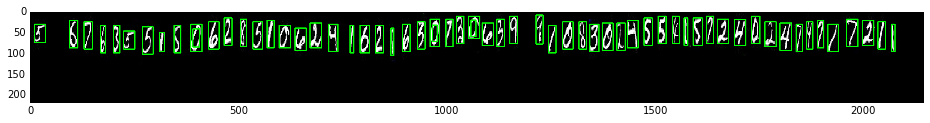

In [14]:
image_color = load_image('images/ulazni_set.jpg')
img = invert(image_bin(image_gray(image_color)))
flag_video = False
img_bin = erode(dilate(img))
img_bin = cv2.erode(img, np.ones((2,2)), iterations=1)
selected_regions, numbers = select_roi(image_color.copy(), img_bin)
display_image(selected_regions)

In [16]:
alphabet = ["5", "6", "7", "6", "3", "5", "5", "1", "5", "0", "6", "2", "8", "5", "1", "0", "6", "2", "4", "1", "6", "2", "1", "6", "3","0", "7", "3", "0", "6", "3", "9", "9", "1", "0", "8", "3", "0","2", "4", "5", "5", "4", "1", "5", "1", "2", "4", "0", "2"]
print len(alphabet)

50


In [17]:
ann = create_ann()
for i in range(0,30,10):
    inputs = prepare_for_ann(numbers[i:i+10])
    print len(inputs)
    outputs = convert_output(alphabet[i:i+10])

    ann = train_ann(ann, inputs, outputs)

10
10
10


['5', '7', '6', '7', '6', '3', '0', '0', '5', '5', '5']


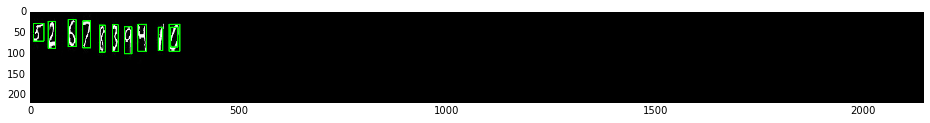

In [18]:
test_color = load_image('images/ulazni_set2.jpg')
test = invert(image_bin(image_gray(test_color)))
test_bin = erode(dilate(test))
#test = cv2.erode(test_bin, np.ones((2,2)), iterations=6)
#test = cv2.dilate(test_bin, np.ones((2,2)), iterations=1)
#test = cv2.erode(test_bin, np.ones((2,2)), iterations=1)
selected_test, test_numbers = select_roi(test_color.copy(),test)
display_image(selected_test)
test_inputs = prepare_for_ann(test_numbers)
result = ann.predict(np.array(test_inputs, np.float32))
print display_result(result, alphabet)

In [22]:
%pylab inline 
import cv2
from IPython.display import clear_output
vid = cv2.VideoCapture("video-0.avi")
suma = 0
flag_video = Trueflag = True
try:
    while(True):
        # Capture frame-by-frame
        ret, frame = vid.read()
        if not ret:
            # Release the Video Device if ret is false
            vid.release()
            # Message to be displayed after releasing the device
            print "Released Video 11 Resource"
            flag_video = False
            break
        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame,(1500,1500), interpolation = cv2.INTER_NEAREST)
        fr = frame.copy()
        fr_bin = remove_noise(image_bin(image_gray(fr)))

        
        #fr_bin = cv2.erode(fr_bin, np.ones((2,2)), iterations=1)
        
        selected, numbers = select_roi(fr.copy(), fr_bin)
        test_inputs = prepare_for_ann(numbers)
        result = ann.predict(np.array(test_inputs, np.float32))
        result = np.frombuffer(result)
        for n in range(0,len(result)):
            suma += int(alphabet[winner(result)])
        # Turn off the axis
        axis('off')
        # Title of the window
        title(suma)
        # Display the frame
        imshow(selected)
        show()
        # Display the frame until new frame is available
        clear_output(wait=True)
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()
    # Message to be displayed after releasing the device
    print "Released Video"
    flag_video = False

Released Video
